In [69]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [96]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [87]:
## Photon Operator
k_photon = 300000. # unit: kcal/mol/angstrom^2 # 5000.
sigma_photon = 1 / sqrt(2 * k_photon);

In [97]:
e_norm

2.0

In [89]:
sigma_photon

0.0012909944487358056

### Part 3: Read Trajectory

#### physical parameters about simulations

In [5]:
save_freq = 1e-3 # unit: s, Save trajectory per 10e-3 s
total_times = 10 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [60]:
potential_type = "triple_well" # harmonic_well double_well triple_well
type_idx = 0;

In [61]:
# Read simulated trajectory from jld file
f_in = @sprintf "/home/yizaochen/codes/julia/md_pisl/trajectory/%s_%d.jld" potential_type type_idx
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
p_eq = rho_eq .* rho_eq;
D = load(f_in, "D");

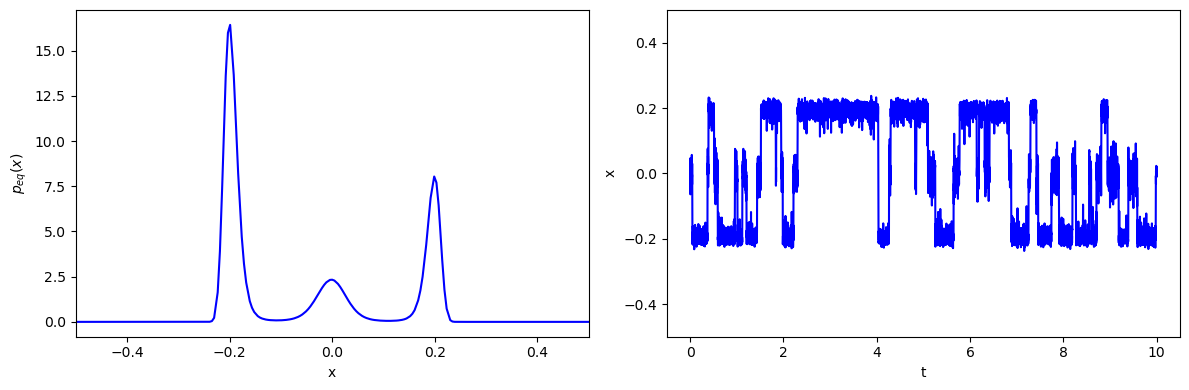

In [62]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.set_xlim(-0.5, 0.5)

ax = axes[2]
ax.plot(t_record, y_record, color="blue")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

### Part 4: Read EM Result

In [63]:
f_in_pcontain = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_%s_%d.jld" potential_type type_idx
p_container = load(f_in_pcontain, "p_container");

In [64]:
lastem_id = 12 # harmonic: 4, double_well: 23, triple_well: 12
p_em = zeros(length(p_eq),1)
p_em[:,1] = p_container[lastem_id+1, :];

### Part 5: Scan Log-likelihood when change D

In [78]:
Nv = 72
D_answer = 1.
#l_answer_p_em = get_loglikelihood(Nh, Np, xratio, xavg, p_em, D_answer, Nv, tau, y_record, save_freq, k_photon)
#l_answer_p_eq = get_loglikelihood(Nh, Np, xratio, xavg, p_eq, D_answer, Nv, tau, y_record, save_freq, k_photon);

In [90]:
D_array = range(0.1, stop=3,length=30)
l_array_p_em = zeros(length(D_array))
l_array_p_eq = zeros(length(D_array))
idx = 1
for D_test in D_array
    #l_array_p_em[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p_em, D_test, Nv, tau, y_record, save_freq, k_photon)
    l_array_p_eq[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p_eq, D_test, Nv, tau, y_record, save_freq, k_photon)
    idx += 1
end

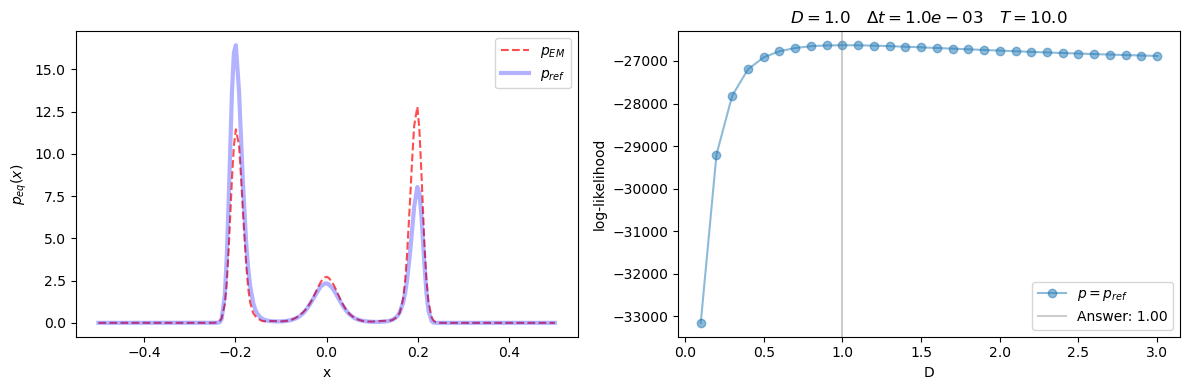

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_em, "--", color="red", alpha=0.7, label="\$p_{EM}\$")
ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}\$")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

ax = axes[2]
#ax.plot(D_array, l_array_p_em, "-o", alpha=0.5, label="\$p=p_{EM}\$")
ax.plot(D_array, l_array_p_eq, "-o", alpha=0.5, label="\$p=p_{ref}\$")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
label = @sprintf "Answer: %.2f" D
ax.axvline(1, color="grey", alpha=0.4, label=label)
ax.legend()
title = @sprintf "\$D=%.1f~~~\\Delta t=%.1e~~~T=%.1f~\$" D save_freq total_times
ax.set_title(title)

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/D_scan_%s_%d.svg" potential_type type_idx)
plt.show()

In [92]:
l_array_p_eq

30-element Array{Float64,1}:
 -33152.73344288596
 -29197.516353561045
 -27813.90458424759
 -27196.460117500425
 -26913.210390789962
 -26771.557384217183
 -26696.05400595019
 -26652.12371541503
 -26634.497947012365
 -26629.419240252788
 -26631.650418251935
 -26639.681935990484
 -26651.072914417957
      ⋮
 -26741.250520679394
 -26756.376776834684
 -26771.10783405217
 -26785.3872867823
 -26799.226593889653
 -26812.500716831528
 -26825.211940293306
 -26837.51891131126
 -26849.241953552388
 -26860.47457740097
 -26871.243221367324
 -26881.568272723496